In [1]:
# Import module
from data import YahooFinanceApi, create_connection
from data import SQLRepository

# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3   

from arch import arch_model


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Read in data

In [30]:
# Fetch data through customised class
ticker = "BTC-USD"
df = YahooFinanceApi(ticker, period = "10y").fetch_data()
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-01-15,41715.066406,43319.722656,41705.417969,42511.968750,42511.968750,22320220558
2024-01-16,42499.335938,43566.273438,42085.996094,43154.945312,43154.945312,24062872740
2024-01-17,43132.101562,43189.890625,42189.308594,42742.652344,42742.652344,20851232595


---
Four assert statements to test the output of your fetch_data method of the customised YahooFinanceApi class

In [31]:
# Does `get_daily` return a DataFrame?
assert isinstance(df, pd.DataFrame)

# Does DataFrame have 5 columns?
assert df.shape[1] == 6, f"Expected 5 columns but got {df.shape[1]}"

# Does DataFrame have a DatetimeIndex?
assert isinstance(df.index, pd.DatetimeIndex)

# Is the index name "date"?
assert df.index.name == "date"

# Does DataFrame have correct column names?
assert all(df.columns == ['open', 'high', 'low', 'close', 'adj close', 'volume'])

In [32]:
# Create connection using a customised method
my_con = create_connection("test_run")

In [33]:
# Instatiate repository
repo = SQLRepository(my_con)

---
Two tests for the SQLRepository class

In [34]:
# Does `repo` have a "connection" attribute?
assert "connection" in repo.__dict__

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

In [35]:
# Insert data gotten through API to SQL database
response = repo.insert_table(ticker, df, if_exists= "replace")

# Does my method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

In [36]:
# Fetch data from SQL database
df = repo.read_table(ticker, limit = 2500)

### Perform EDA on data

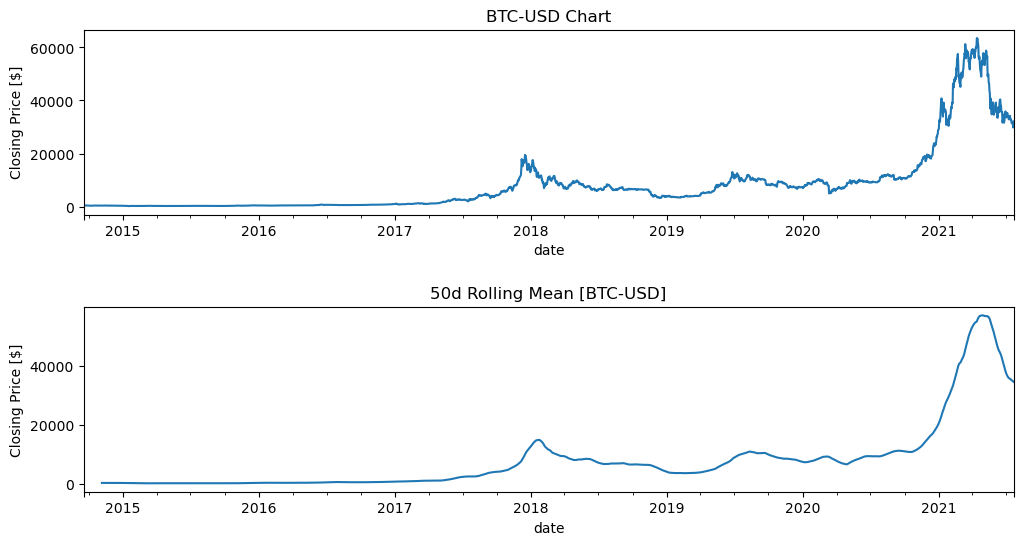

In [37]:
fig, axs = plt.subplots(2,1, figsize = (12,6))

df["close"].plot(ax = axs[0], title = f"{ticker} Chart", ylabel = "Closing Price [$]")

df["close"].rolling(50).mean().plot(ax = axs[1], title = f"50d Rolling Mean [{ticker}]", ylabel = "Closing Price [$]")

plt.subplots_adjust(hspace= 0.5)

In [38]:
returns = df["close"].pct_change()
returns.fillna(0, inplace= True)

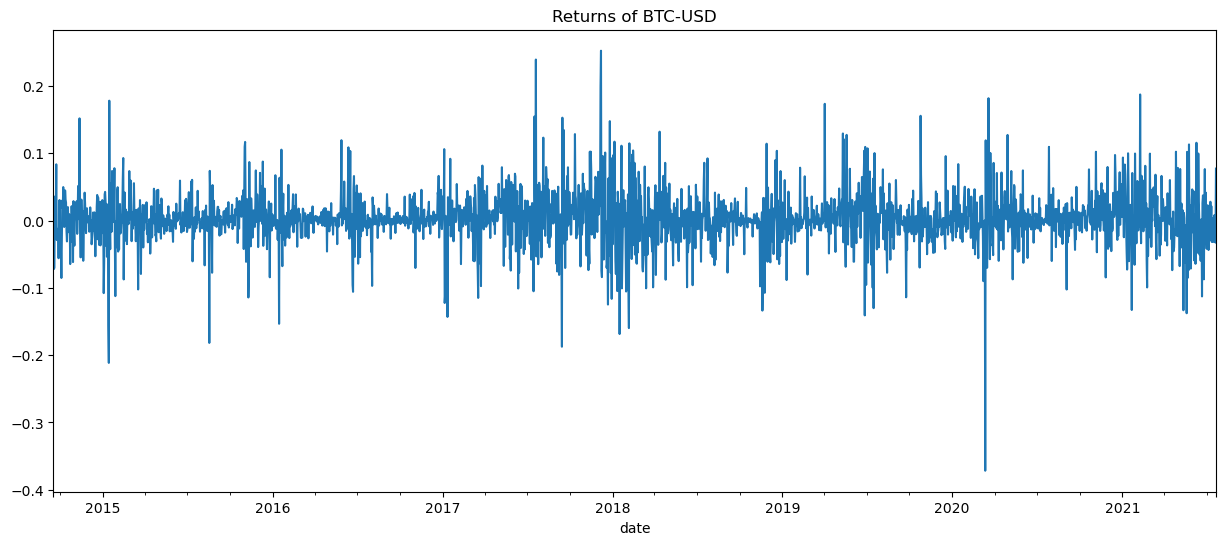

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))

returns.plot()

plt.title(f"Returns of {ticker}");


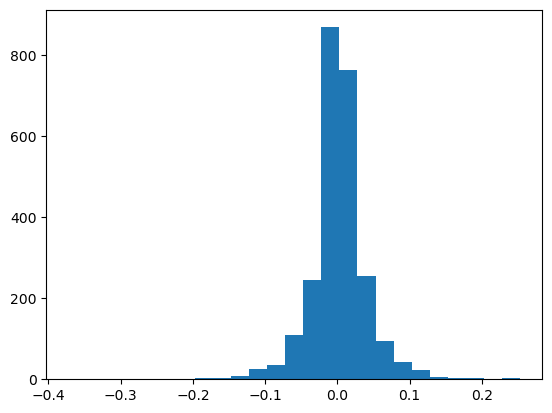

In [40]:
plt.hist(returns, bins = 25);

### Calculate daily and annual volatility

In [41]:
daily_volatility = returns.std()

print(f"{ticker}'s daily volatility is {daily_volatility}")

BTC-USD's daily volatility is 0.03922554240140251


In [42]:
annual_volatility = returns.std() * np.sqrt(356)
print(f"{ticker}'s annual volatility is {annual_volatility}")

BTC-USD's annual volatility is 0.740106053819035


### Calculate rolling volatility of the asset

In [43]:
rolling_50d_volatility = returns.rolling(50).std().dropna()
rolling_50d_volatility.head()

date
2014-11-05    0.034320
2014-11-06    0.034653
2014-11-07    0.033351
2014-11-08    0.031997
2014-11-09    0.032451
Name: close, dtype: float64

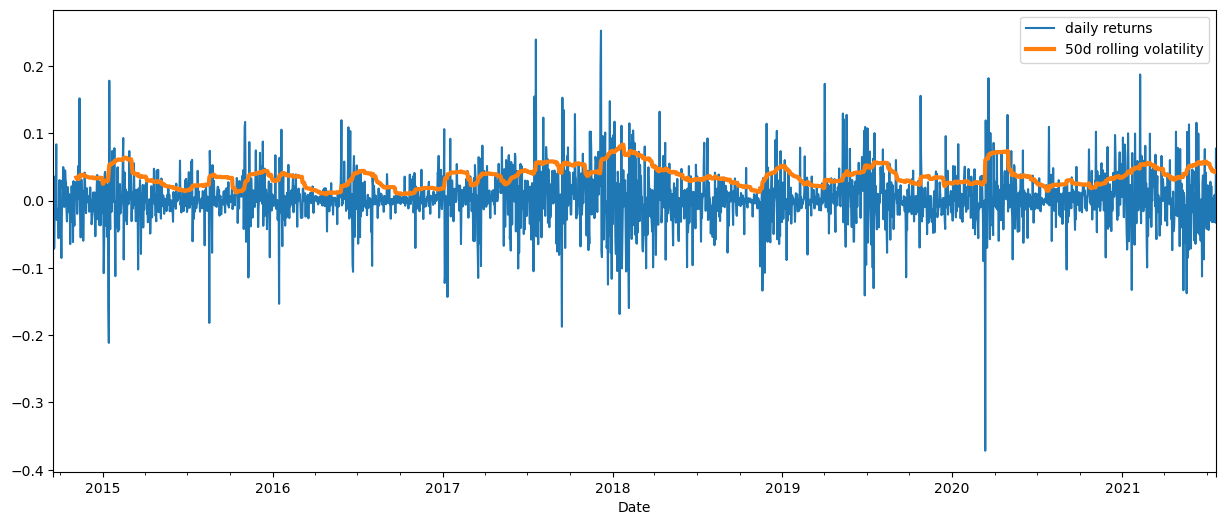

In [44]:
fig, ax = plt.subplots(figsize = (15,6))

returns.plot(ax =ax, label = "daily returns")
rolling_50d_volatility.plot(ax = ax, linewidth = 3, label = "50d rolling volatility")

plt.xlabel("Date")

plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

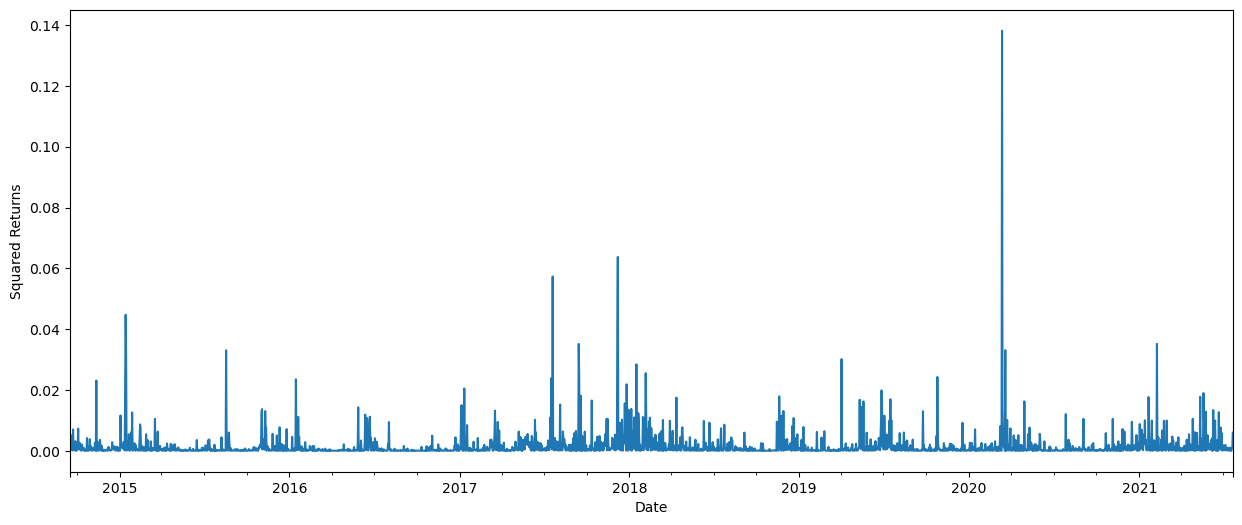

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(returns ** 2).plot()

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

Now it's much easier to see that:

1. we have periods of high and low volatility, and 
2. high volatility days tend to cluster together. 



Text(0, 0.5, 'Correlation Coefficient')

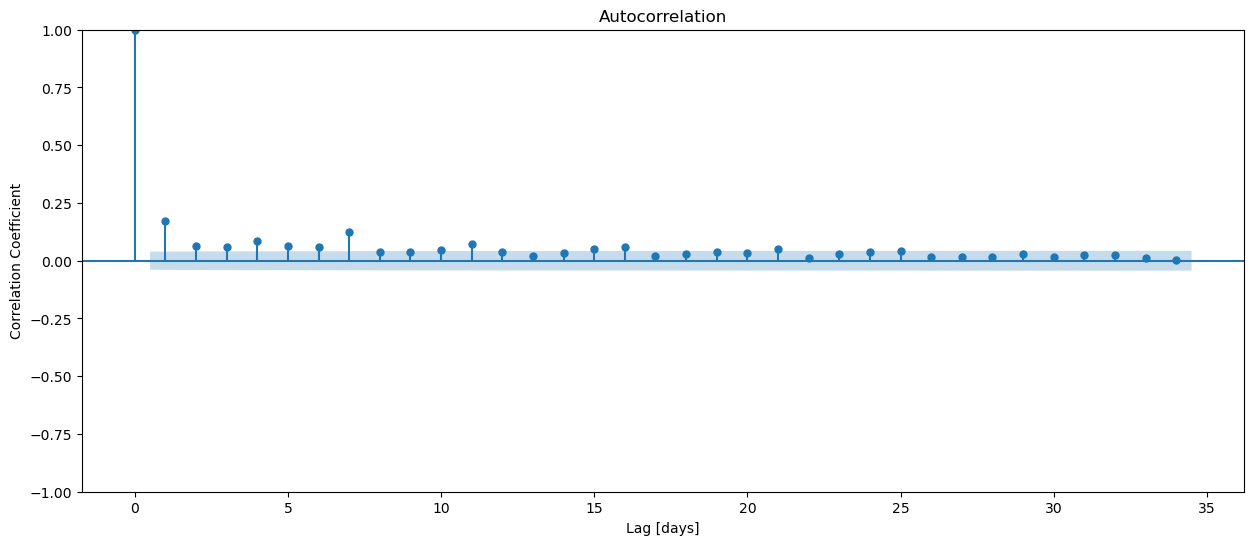

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(returns**2, ax = ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

C:\Users\Eby\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation Coefficient')

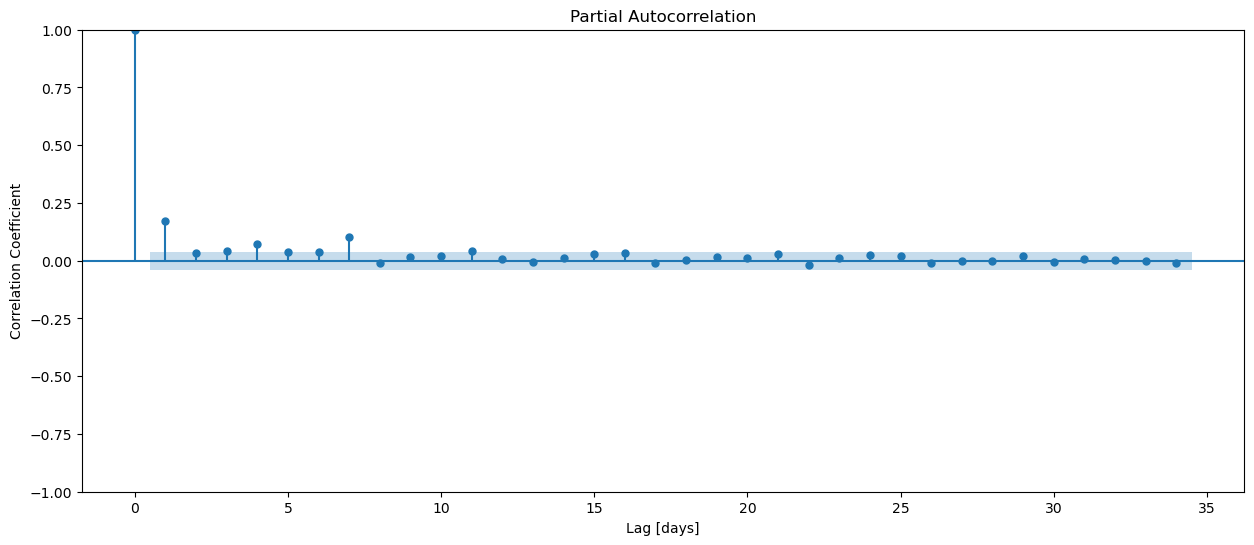

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(returns**2, ax = ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

## Split Data

In [48]:
cutoff_test = int(0.8 * len(returns))
y_train = returns[:cutoff_test]

print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)
y_train.tail()

y_train type: <class 'pandas.core.series.Series'>
y_train shape: (2000,)


date
2020-03-04   -0.003703
2020-03-05    0.036951
2020-03-06    0.004823
2020-03-07   -0.023304
2020-03-08   -0.089993
Name: close, dtype: float64

In [49]:
y_train.head()

date
2014-09-17    0.000000
2014-09-18   -0.071926
2014-09-19   -0.069843
2014-09-20    0.035735
2014-09-21   -0.024659
Name: close, dtype: float64

## Build Model

In [50]:
# Build and train model
model = arch_model(
    y_train,
    p = 1, 
    q = 1,
    rescale = False 
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3908.15
Distribution:                  Normal   AIC:                          -7808.30
Method:            Maximum Likelihood   BIC:                          -7785.89
                                        No. Observations:                 2000
Date:                Fri, Jan 19 2024   Df Residuals:                     1999
Time:                        17:01:24   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6868e-03  6.350e-04      2.656  7.901e-03 [4.422e-04,2.931e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.1805e-05  2.202e-05      3.261  1.112e-03 [2.864e-05,1.150e-04]
alpha[1]       0.1376  2.895e-02      4.753  2.000e-06   [8.088e-02,  0.194]
beta[1]        0.8211  2.808e-02     29.240 5.937e-188     [  0.766,  0.876]
============================================================================

Covariance estimator: robust
"""

---
A time series plot with the returns and the conditional volatility for your model

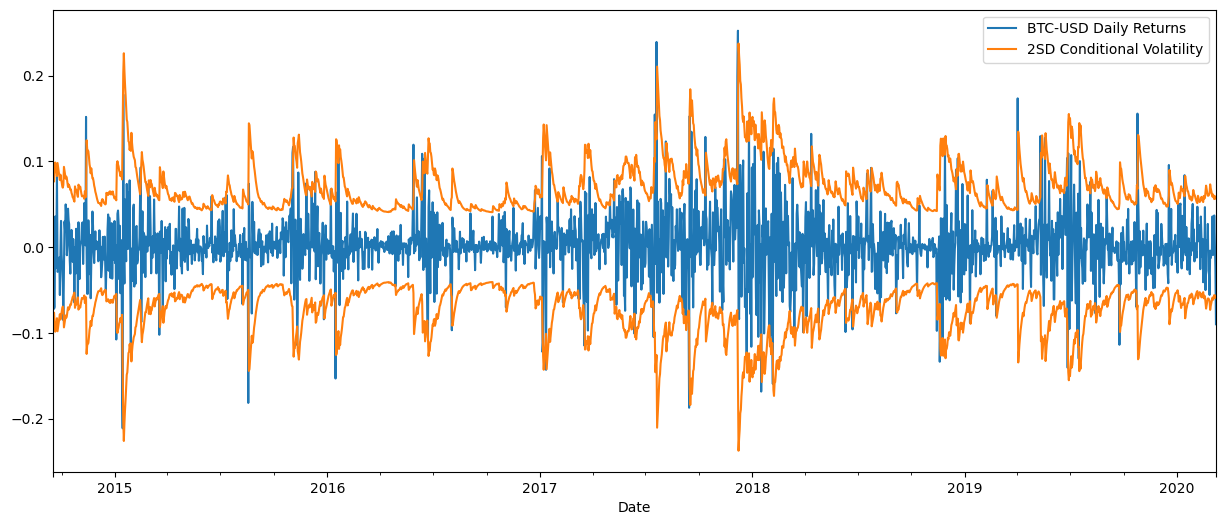

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_train.plot(ax = ax, label = f"{ticker} Daily Returns")

# Plot conditional volatility * 2
(model.conditional_volatility * 2).plot(ax = ax, label = "2SD Conditional Volatility", color = "C1")

# Plot conditional volatility * -2
(model.conditional_volatility.rename("") * -2).plot(ax = ax, color = "C1")


# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

---
A time series plot of the standardized residuals for your model

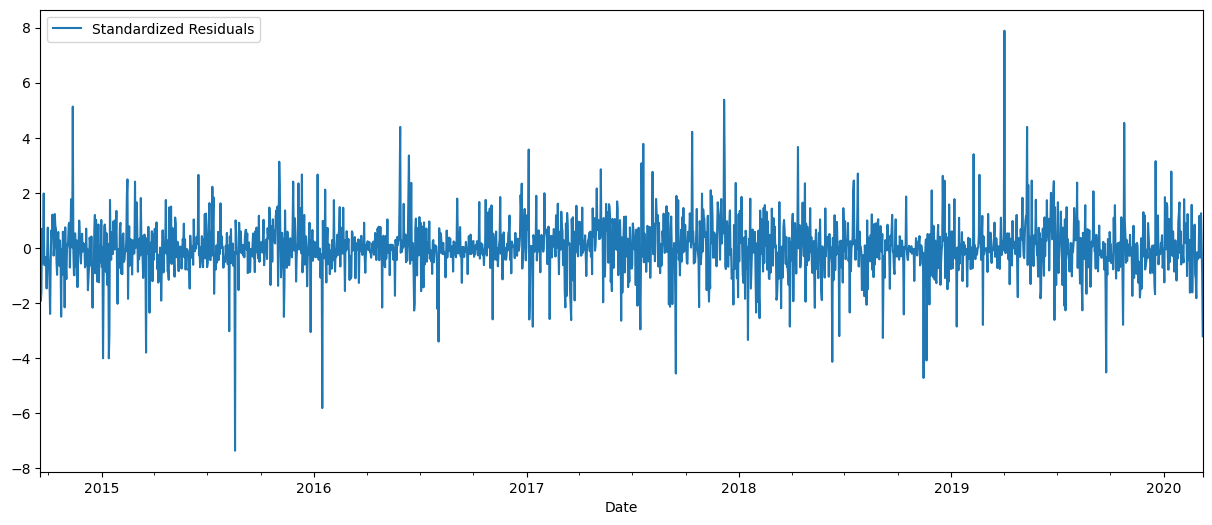

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax = ax, label = "Standardized Residuals")

# Add axis labels
plt.xlabel("Date")

# Add legend
plt.legend();

---
A histogram with 25 bins of the standardized residuals for your model

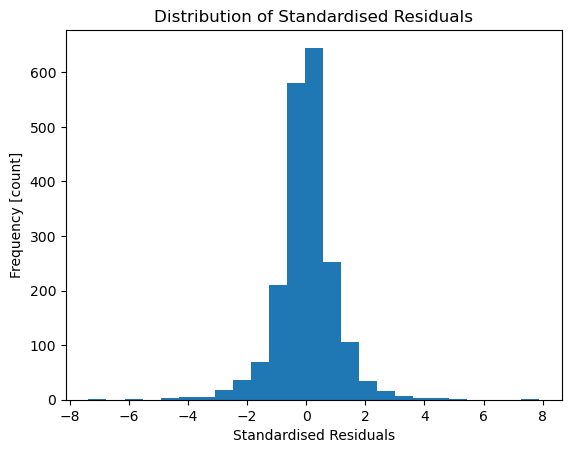

In [53]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins = 25)

# Add axis labels
plt.xlabel("Standardised Residuals")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardised Residuals");

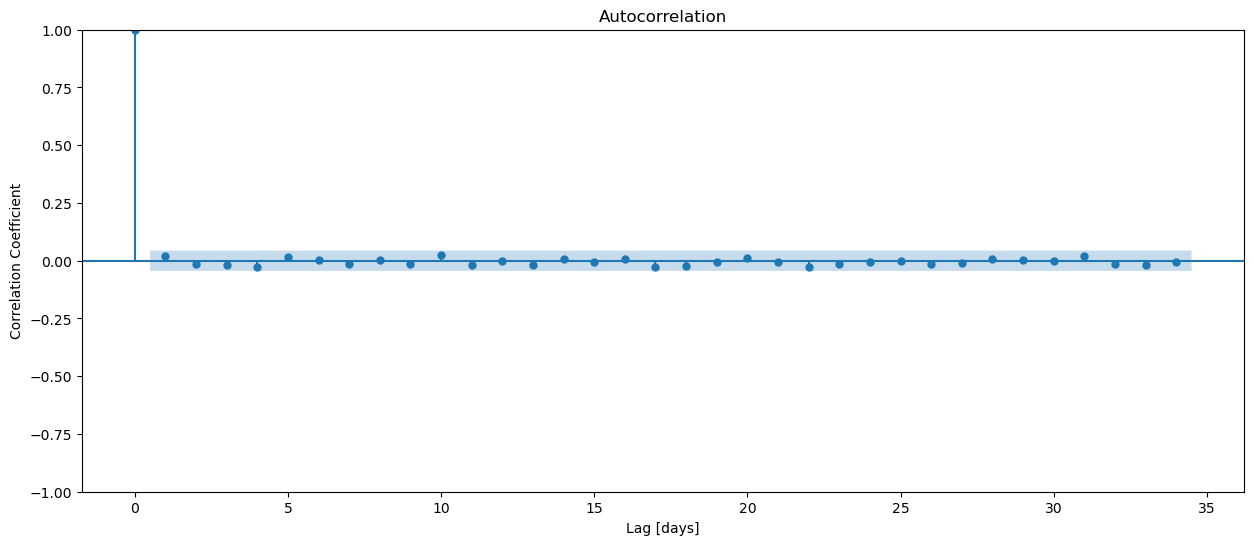

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid **2, ax = ax)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Lag [days]");

In [55]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(returns) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = returns.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1,q=1, rescale=False).fit(disp =0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon= 1, reindex = False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2020-03-09    0.043574
2020-03-10    0.041350
2020-03-11    0.038416
2020-03-12    0.035829
2020-03-13    0.153608
dtype: float64

---
Perform walk-forward validation on the model

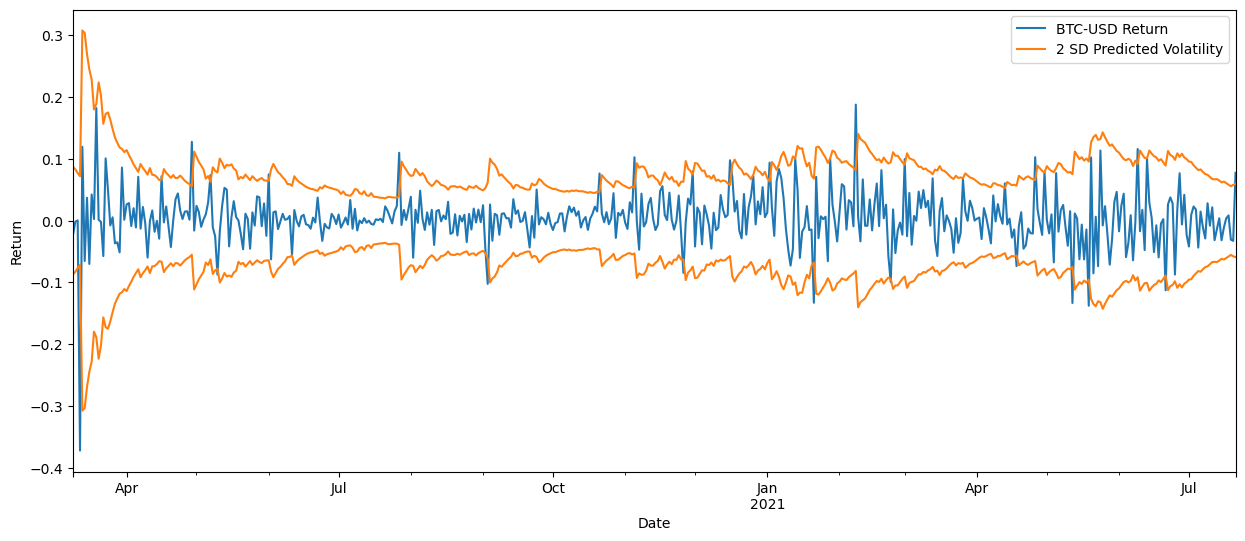

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
returns.tail(test_size).plot(ax=ax, label=f"{ticker} Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

---
One additional step we could do to evaluate how our model performs on the test data would be to plot the ACF of the standardized residuals for only the test set

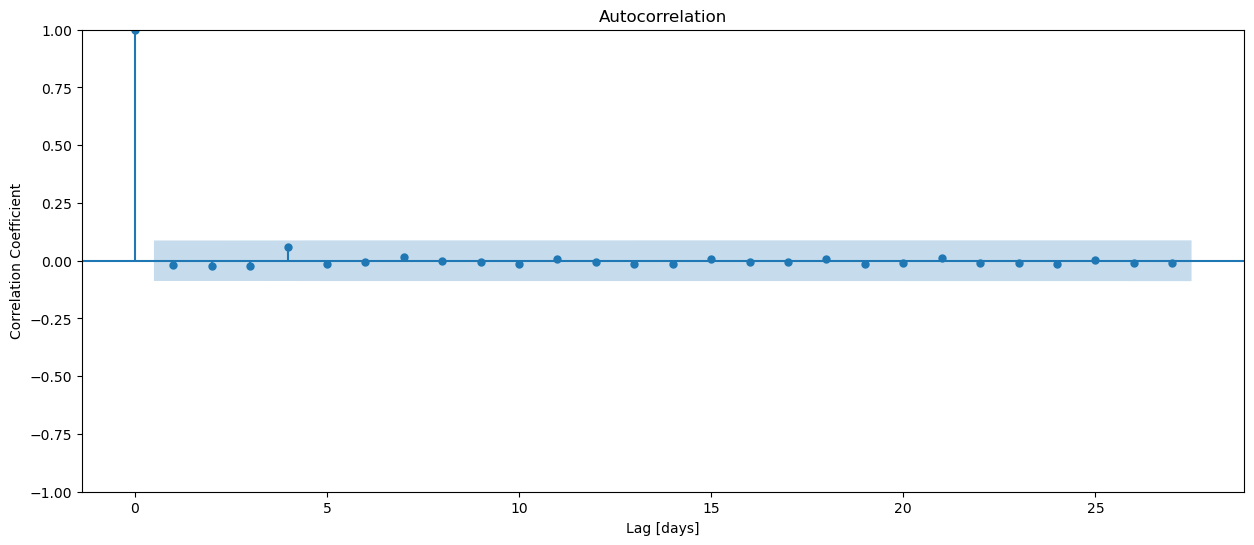

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(model.std_resid.tail(test_size) **2, ax = ax)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Lag [days]");

# Communicate

In [59]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days = 1)

    # Create date range
    prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [i.isoformat() for i in prediction_dates]

    # Extract predictions from DataFrame, get square root
    predictions = prediction.iloc[0,0:len(prediction_index)].values ** 0.5

    # Combine `data` and `prediction_index` into Series
    formatted_data = pd.Series(predictions, prediction_index)

    # Return Series as dictionary
    return dict(formatted_data)

In [60]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2021-07-21T00:00:00': 0.029545253778369023,
 '2021-07-22T00:00:00': 0.02976896548998274,
 '2021-07-23T00:00:00': 0.029986583684353134,
 '2021-07-26T00:00:00': 0.03019832798170853,
 '2021-07-27T00:00:00': 0.030404406647681712,
 '2021-07-28T00:00:00': 0.030605017413804093,
 '2021-07-29T00:00:00': 0.030800348221403984,
 '2021-07-30T00:00:00': 0.0309905778975771,
 '2021-08-02T00:00:00': 0.031175876770755298,
 '2021-08-03T00:00:00': 0.03135640723242757}